# Сборный проект — 2

# Вторая задача 
Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Задача 2: Предсказание увольнения сотрудника из компании

#  Шаг 1. Загрузка данных

In [38]:
!pip install -q phik
!pip install -q --upgrade scikit-learn
!pip install seaborn
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

from phik import phik_matrix
from scipy.stats import mstats, pearsonr

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, QuantileTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, mean_squared_error, mean_absolute_percentage_error, r2_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

from sklearn.datasets import make_classification

Для этой задачи можно использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

# Шаг 1. Загрузка данных

In [40]:
# Тренировочная выборка
train_quit = pd.read_csv(r'C:\GitProjects\supervised_learning_project\data\task2\train2\train_quit.csv')

# Выводим первые 5 строк данных
display(train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [41]:
print(train_quit.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


Тренировочная выборка train_quit состоит из 4000 записей с 10 признаками, содержит пропущенные значения в столбцах dept - 6 и level - 4, их можно обработать с помощью методов заполнения, таких как среднее или мода. Все признаки являются категориальными или числовыми.
Анализ категориальных признаков: dept имеет 5 уникальных значения, level - 3, workload - 3, last_year_promo и last_year_violations - по 2 уникальных значения.
Анализ числовых признаков: employment_years варьируется от 1 до 10 лет, supervisor_evaluation - от 1 до 5, salary - от 10000 до 100000, quit - 2 уникальных значения.
Набор данных хорошо структурирован и содержит минимальное количество пропущенных значений. Категориальные признаки имеют ограниченное количество уникальных значений, что упрощает их обработку. Числовые признаки имеют разумные диапазоны и распределения. Нет явных проблем с корреляцией между признаками. В целом, набор данных находится в хорошем состоянии и готов к дальнейшему анализу.

In [42]:
# Тестовая выборка
test_features = pd.read_csv(r'C:\GitProjects\supervised_learning_project\data\task2\test2\test_features.csv')

# Выводим первые 5 строк данных
display(test_features.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [43]:
print(test_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


Тестовая выборка test_features состоит из 2000 записей с 9 признаками, содержит пропущенные значения в столбцах dept - 2 и level - 1, их можно обработать с помощью методов заполнения, таких как среднее или мода. Все признаки являются категориальными или числовыми.
Анализ категориальных признаков: dept имеет 5 уникальных значения, level - 3, workload - 3, last_year_promo и last_year_violations - по 2 уникальных значения.
Анализ числовых признаков: employment_years варьируется от 1 до 10 лет, supervisor_evaluation - от 1 до 5, salary - от 10000 до 100000.
Набор данных хорошо структурирован и содержит минимальное количество пропущенных значений. Категориальные признаки имеют ограниченное количество уникальных значений, что упрощает их обработку. Числовые признаки имеют разумные диапазоны и распределения. Нет явных проблем с корреляцией между признаками. В целом, набор данных находится в хорошем состоянии и готов к дальнейшему анализу.

In [44]:
# Целевой признак тестовой выборки
test_target_quit = pd.read_csv(r'C:\GitProjects\supervised_learning_project\data\task2\test2\test_target_quit.csv')

# Выводим первые 5 строк данных
display(test_target_quit.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [45]:
print(test_target_quit.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


Целевой признак тестовой выборки data_target состоит из 2000 записей с 2 признаками, не содержит пропущенных значений.

# Шаг 2. Предобработка данных

Изучите данные и при необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [46]:
# Проверяем наличие дубликатов в train_quit
train_quit.duplicated().sum()

np.int64(0)

In [47]:
# Проверяем наличие дубликатов в test_features
test_features.duplicated().sum()

np.int64(0)

In [48]:
# Проверяем наличие дубликатов в test_target_quit
test_target_quit.duplicated().sum()

np.int64(0)

In [49]:
# Проверка на наличие пропусков в train_quit
missing_values = train_quit.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [50]:
# Заменяем 'sinior' на 'senior' в столбце 'level'
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

# Проверяем изменения
print(train_quit['level'].value_counts())

level
junior    1949
middle    1694
senior     357
Name: count, dtype: int64


In [51]:
# Проверка на наличие пропусков в test_features
missing_values = test_features.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [52]:
# Проверка на наличие пропусков в test_target_quit
missing_values = test_target_quit.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id      0
quit    0
dtype: int64

In [53]:
# Заменяем 'sinior' на 'senior' в столбце 'level' в test_target_quit
test_features['level'] = test_features['level'].replace('sinior', 'senior')

# Проверяем изменения
print(test_features['level'].value_counts())

# Заменяем пробелы на np.nan для всех категориальных признаков
for col in test_features.select_dtypes(include=['object']).columns:
    test_features[col] = test_features[col].replace(' ', np.nan)

# Проверяем уникальные значения после замены
for col in test_features.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(test_features[col].unique())

level
junior    974
middle    854
senior    171
Name: count, dtype: int64
Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'senior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' nan]
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


In [54]:
# Получаем уникальные значения для категориальных признаков train_quit
for col in train_quit.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(train_quit[col].unique())
    display()

Уникальные значения для столбца dept:
['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для столбца level:
['middle' 'junior' 'senior']
Уникальные значения для столбца workload:
['high' 'medium' 'low']
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']
Уникальные значения для столбца quit:
['no' 'yes']


In [55]:
# Получаем уникальные значения для категориальных признаков test_features
for col in test_features.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(test_features[col].unique())
    display()

Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'senior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' nan]
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


# Проведена проверка на пропуски и дубликаты
Пропуски в train_quit: dept - 6, level - 4, в test_features: dept - 2, level - 1 и дубликатов нет. В уникальных значениях для категориальных признаков train_quit dept - nan, level - nan, в test_features: dept - ' ', level - nan, workload - ' '. Выполнена предобработка.

# Шаг 3. Исследовательский анализ данных

3.1. Проведите исследовательский анализ данных.
3.2. Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.
3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

# Исследовательский анализ данных

In [56]:
# Отбор уволенных сотрудников
terminated_employees = train_quit[train_quit['quit'] == 'yes']

# Проведение описательной статистики
description = terminated_employees.describe(include='all')

# Вывод результата
display(description)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,1128.000000,1128,1128,1128,1128.000000,1128,1128,1128.000000,1128.000000,1128
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,1
top,NaN,sales,junior,low,NaN,no,no,NaN,NaN,yes
freq,NaN,407,1003,519,NaN,1127,900,NaN,NaN,1128
mean,544544.457447,NaN,NaN,NaN,1.844858,NaN,NaN,3.046099,23885.106383,NaN
std,258059.498361,NaN,NaN,NaN,1.274920,NaN,NaN,0.973291,9351.599505,NaN
min,100222.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,NaN
25%,325073.000000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,16800.000000,NaN
50%,545003.500000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000,NaN
75%,756296.000000,NaN,NaN,NaN,2.000000,NaN,NaN,4.000000,27600.000000,NaN


В выборке 1128 уволившихся сотрудников. Сотрудники распределены по 5 различным отделам, при этом наибольшее количество (407) относится к отделу продаж. Это может указывать на высокую текучесть кадров в данном отделе или на особенности его работы.

Представлены три уровня должностей, среди которых наибольшее количество (1003) составляет уровень "junior". Это может свидетельствовать о том, что младшие сотрудники чаще всего увольняются, возможно, из-за недостатка карьерного роста или неудовлетворенности условиями труда.

Представлены три категории нагрузки, среди которых преобладает "low" (519 случаев) - сотрудники с низкой нагрузкой чаще увольняются, возможно, из-за недостатка вызовов или интересных задач.

Среднее количество лет работы уволившихся сотрудников составляет примерно 1.84 года - относительно небольшой срок, что может говорить о высокой текучести кадров среди новых сотрудников. Минимальный стаж составляет 1 год, а максимальный — 10 лет, что также подтверждает наличие как новых, так и более опытных сотрудников в выборке.

1127 не получили продвижение в прошлом году, что может быть связано с недостатком карьерных возможностей или низкой мотивацией.

900 уволившихся сотрудников не имели нарушений в прошлом году - большинство уволившихся сотрудников соблюдали правила и нормы компании, что может быть положительным показателем в отношении их профессиональной дисциплины.

Средняя оценка от руководства составляет примерно 3.05 из 5, с стандартным отклонением 0.97 - в целом сотрудники получили среднюю оценку, значит они выполняли свои обязанности на удовлетворительном уровне, но было пространство для улучшения. Минимальная оценка составляет 1, а максимальная — 5, были как низкооцененные сотрудники, так и высокоэффективные работники в выборке.

25% сотрудников получили оценку 3 или ниже - часть уволившихся сотрудников не соответствовала ожиданиям руководства.
Половина уволившихся (50%) получила оценку 3, что подчеркивает средний уровень производительности. 75% сотрудников получили оценку 4 или ниже, значит лишь небольшая часть сотрудников (25%) была высоко оценена.

Средняя зарплата уволившихся сотрудников составляет 23885.11, что может служить ориентиром для оценки уровня заработной платы в компании и сравнения с рыночными стандартами. Стандартное отклонение составляет 9351.60, существует значительная вариативность зарплат среди уволившихся сотрудников. Минимальная зарплата составляет 12000, а максимальная — 79200, что говорит о широком диапазоне зарплат в компании и может быть связано с различиями в должностях, опыте и квалификации сотрудников. 25% сотрудников зарабатывали 16800 или меньше. Половина (50%) сотрудников имела зарплату 22800 или ниже. 75% сотрудников зарабатывали 27600 или меньше, что говорит о том, что только четверть сотрудников получала зарплату выше этого уровня.

Необходимо провести более глубокий анализ причин увольнения, особенно среди сотрудников с низкими оценками. Возможно, стоит рассмотреть возможность улучшения условий труда и карьерного роста для этих сотрудников, разработать программы повышения квалификации и развития для сотрудников, чтобы повысить их производительность и удовлетворенность работой.
Необходимо провести анализ структуры зарплат в компании, чтобы понять, как она соотносится с рыночными стандартами и конкурентами. Рассмотреть возможность пересмотра компенсационного пакета для удержания талантливых сотрудников, особенно тех, кто находится на верхних уровнях зарплатного диапазона. Если высокая текучесть кадров связана с низкими зарплатами, стоит рассмотреть возможность повышения заработной платы или внедрения дополнительных бонусов и льгот для увеличения удовлетворенности сотрудников.

# Распределение числовых данных в train_quit

C:\Users\Tatyana\AppData\Local\Temp\ipykernel_1880\918205098.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='employment_years', data=train_quit, palette='viridis')
C:\Users\Tatyana\AppData\Local\Temp\ipykernel_1880\918205098.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='supervisor_evaluation', data=train_quit, palette='viridis')


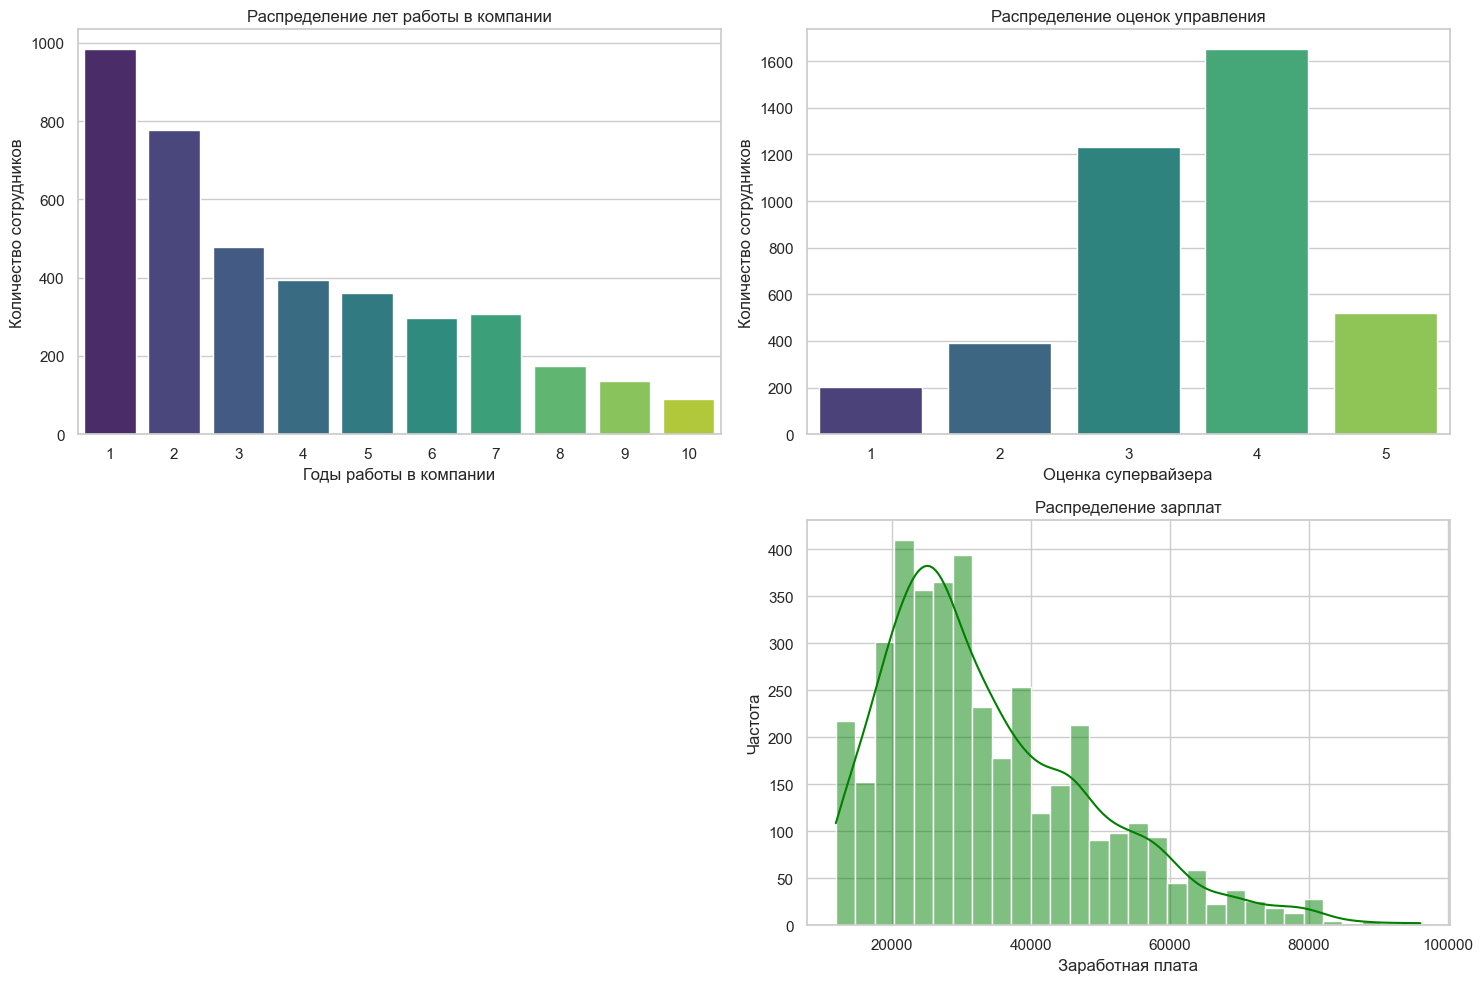

In [57]:
# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

# Создаем фигуру для графиков
plt.figure(figsize=(15, 10))

# Для дискретных признаков
plt.subplot(2, 2, 1)  # График 1: employment_years
sns.countplot(x='employment_years', data=train_quit, palette='viridis')
plt.title('Распределение лет работы в компании')  # Название графика
plt.xlabel('Годы работы в компании')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

plt.subplot(2, 2, 2)  # График 2: supervisor_evaluation
sns.countplot(x='supervisor_evaluation', data=train_quit, palette='viridis')
plt.title('Распределение оценок управления')  # Название графика
plt.xlabel('Оценка супервайзера')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

# Для непрерывных признаков
plt.subplot(2, 2, 4)  # График 4: salary
sns.histplot(train_quit['salary'], bins=30, kde=True, color='green')
plt.title('Распределение зарплат')  # Название графика
plt.xlabel('Заработная плата')  # Подпись оси X
plt.ylabel('Частота')  # Подпись оси Y

plt.tight_layout()  # Улучшает внешний вид графиков
plt.show()  # Отображаем графики

Графики распределения числовых признаков train_quit аналогичны и сопоставимы с data_train

# Распределение категориальных и дискретных данных в train_quit

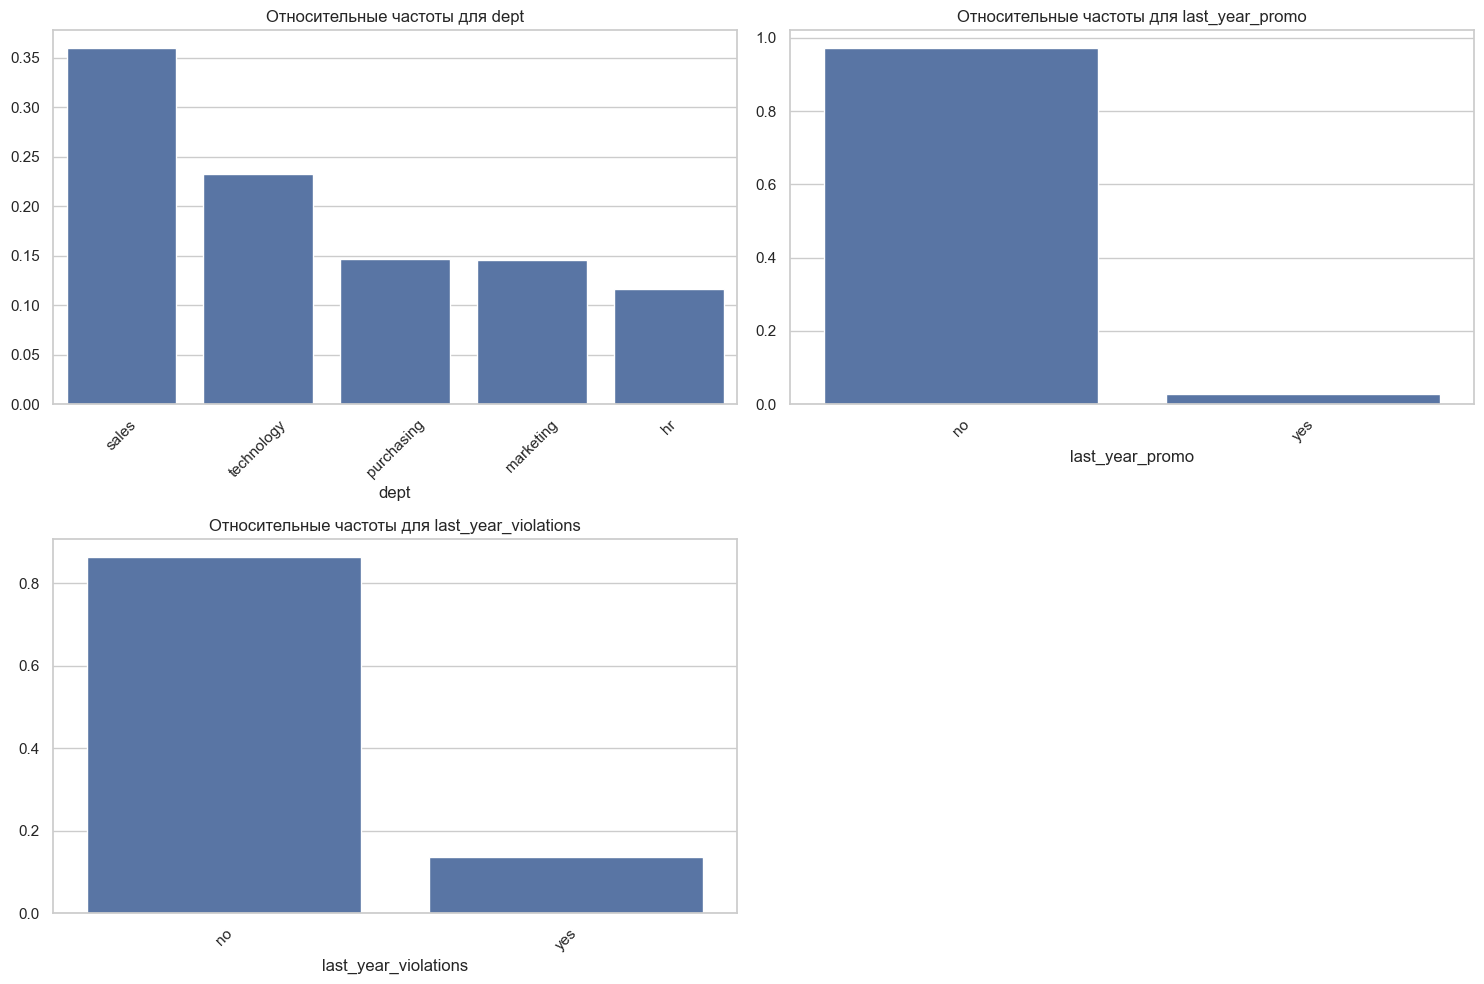

In [58]:
# Категориальные признаки train_quit
categorical_cols = ['dept', 'last_year_promo', 'last_year_violations']

# Анализ и визуализация
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    # Получаем относительные частоты
    relative_freq = train_quit[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Графики распределения категориальных признаков train_quit аналогичны и сопоставимы с data_train

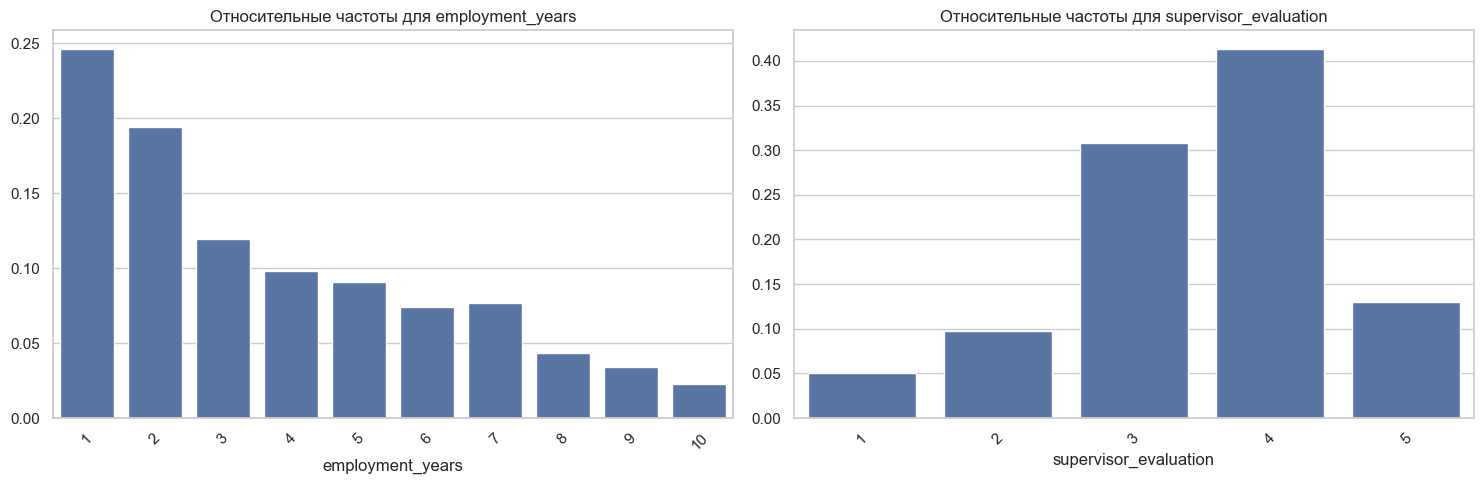

In [59]:
# Дискретные признаки train_quit в относительных показателях
discrete_cols = ['employment_years', 'supervisor_evaluation']

# Анализ и визуализация
plt.figure(figsize=(15, 5))
for i, col in enumerate(discrete_cols, 1):
    plt.subplot(1, 2, i)
    # Получаем относительные частоты
    relative_freq = train_quit[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Определение выбросов в данных train_quit

Медиана supervisor_evaluatione: 4.0


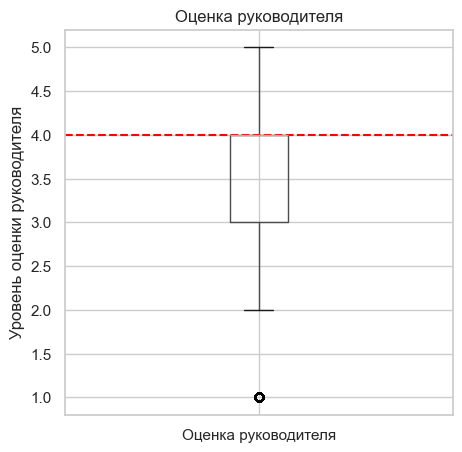

In [60]:
# Создаем boxplot для supervisor_evaluation у train_quit
train_quit[['supervisor_evaluation']].boxplot(figsize=(5, 5))

# Помечаем медиану на графике
median_supervisor_evaluation = np.median(train_quit['supervisor_evaluation'])
plt.axhline(median_supervisor_evaluation, color='red', linestyle='--')

# Выводим медиану
print(f'Медиана supervisor_evaluatione: {median_supervisor_evaluation}')

# Добавляем подписи и заголовок
plt.title('Оценка руководителя')
plt.ylabel('Уровень оценки руководителя')
plt.xticks([1], ['Оценка руководителя'])  # Подписываем ось X

# Показываем график
plt.show()

Медиана salary: 30000.0


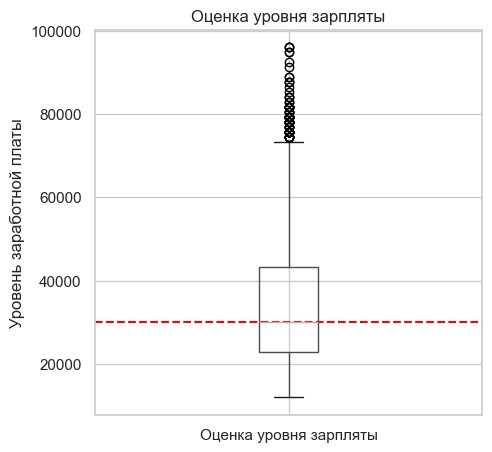

In [61]:
# boxplot для salary у train_quit
train_quit[['salary']].boxplot(figsize=(5, 5))

# Помечаем медиану на графике
median_salary = np.median(train_quit['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# Выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня зарпляты')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Оценка уровня зарпляты'])  # Подписываем ось X

# Показываем график
plt.show()

In [62]:
# Отбор уволенных сотрудников
terminated_employees = train_quit[train_quit['quit'] == 'yes']

# Сравнение средней зарплаты сотрудников terminated_employees с зарплатой остальных
mean_salary_terminated_employees = terminated_employees['salary'].mean()
mean_salary_stayers = train_quit[train_quit['quit'] == 'no']['salary'].mean()

print(f'Средняя зарплата уволившихся сотрудников: {mean_salary_terminated_employees}')
print(f'Средняя зарплата оставшихся сотрудников: {mean_salary_stayers}')

Средняя зарплата уволившихся сотрудников: 23885.106382978724
Средняя зарплата оставшихся сотрудников: 37702.22841225627


In [63]:
# Рассчитываем Q1 и Q3
Q1 = train_quit['salary'].quantile(0.25)
Q3 = train_quit['salary'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим среднее значение в пределах интерквартильного размаха
mean_value = train_quit[(train_quit['salary'] >= lower_bound) & (train_quit['salary'] <= upper_bound)]['salary'].mean()

# Заменяем выбросы на среднее значение
train_quit['salary'] = train_quit['salary'].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)

# Распределение корреляций данных в train_quit

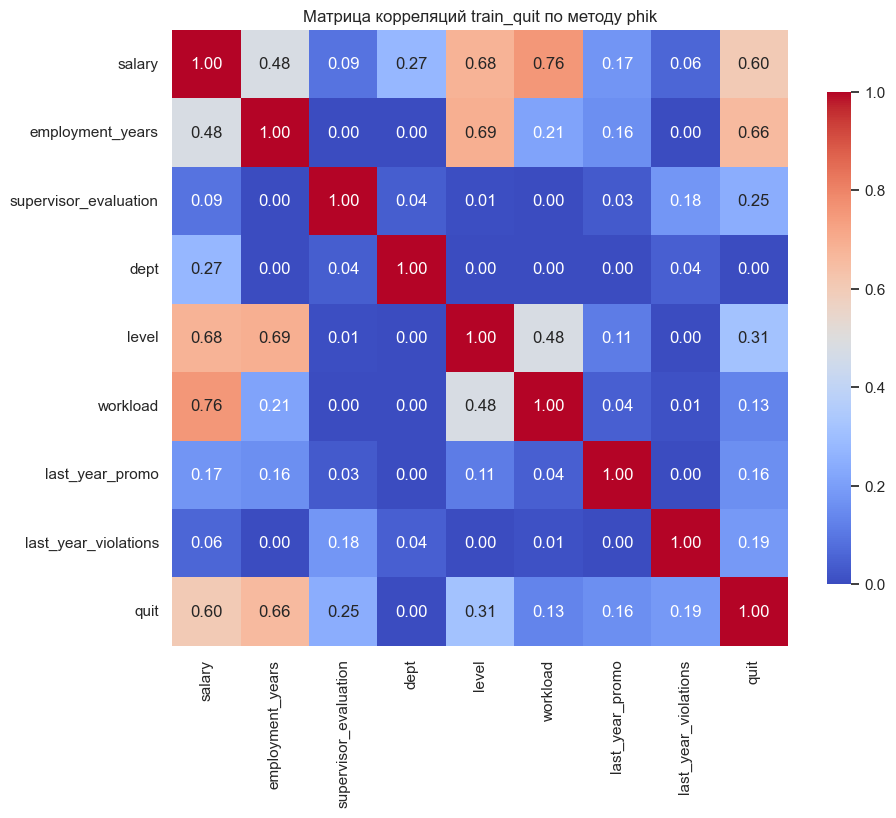

In [64]:
# Определяем колонки, которые будем использовать
# Интервальные (не корреологичные: employment_years и supervisor_evaluation)
interval_cols = ['salary']  # Непрерывные признаки
discrete_cols = ['employment_years', 'supervisor_evaluation']  # Дискретные

# Создаем список всех признаков
all_columns = train_quit.columns.tolist()

# Убираем из всех столбцов интервальные, дискретные и id, чтобы получить категориальные
categorical_cols = [col for col in all_columns if col not in interval_cols + discrete_cols + ['id']]

# Выводим матрицу корреляций с использованием метода phik
correlation_matrix = phik_matrix(train_quit[interval_cols + discrete_cols + categorical_cols], interval_cols=interval_cols)

# Рисуем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций train_quit по методу phik')
plt.show()

1. Самые сильные корреляции - значение 0,76 указывает на сильную + связь между переменными salary и workload. 0,68 указывают на умеренную связь между переменными salary и level, 0,69 - level и employment_years, 0,66 - quit и employment_years. 

С увеличением зарплаты возрастает и рабочая нагрузка - сотрудники с высоким уровнем зарплаты имеют более высокие ожидания в отношении своей рабочей нагрузки или работают на более ответственных позициях и высокие зарплаты связаны с более высокими должностями или уровнями в компании. Сотрудники с большим стажем имеют тенденцию занимать более высокие должности. С увеличением стажа работы вероятность увольнения также возрастает, что может указывать на высокую текучесть кадров среди более опытных сотрудников или на их желание искать новые возможности после определенного времени в одной компании.

2. 0,60 указывают на среднюю + связь между переменными salary и quit, 0,66 - employment_years и salary, 0,48 - level и workload.

Существует непосредственная связь между зарплатой и увольнениями, что может подразумевать, что более низкая зарплата ведет к увольнению. С увеличением стажа работы, как правило, увеличивается и зарплата, что соответствует общей практике в большинстве организаций.

3. Отсутствие корреляции - значения - 0-0,1 указывают на отсутствие линейной связи между переменными, таких корреляций большинство, по целевому признаку quit к слабым относятся: dept (0) - переменные не связаны. Также 0-0,1 имеют - salary и last_year_violations, salary и supervisor_evaluation, supervisor_evaluation и dept, supervisor_evaluation и level, supervisor_evaluation и workload, supervisor_evaluation и employment_years, supervisor_evaluation и last_year_promo, last_year_violations и dept, level, workload, last_year_promo, а last_year_promo никак не связан с dept, workload, last_year_violations, supervisor_evaluation. employment_years никак не связан с dept, last_year_violations, supervisor_evaluation. workload никак не связан с dept, last_year_violations, last_year_promo и supervisor_evaluation.

Многие переменные не имеют статистически значимого влияния на целевой признак. Например, dept и last_year_violations не показывают значимой взаимосвязи с увольнением, не влияют на решение сотрудников уволиться. salary и supervisor_evaluation, также имеют слабую связь с увольнениями, что поднимает вопросы о роли менеджмента и поддержки сотрудников.

4. Слабые связи - 0,1-0,4 - quit и level, workload, last_year_promo, last_year_violations, supervisor_evaluation. salary и dept, last_year_promo. supervisor_evaluation и last_year_violations. last_year_promo и employment_years. employment_years и workload.

quit и level, workload, last_year_promo, last_year_violations, supervisor_evaluation могут указывать на факторы, которые необходимо учитывать в дальнейшем анализе, но они не являются главными детерминантами увольнения. Корреляции между supervisor_evaluation и last_year_violations и last_year_promo также показывают, что оценки супервайзеров не всегда соответствуют результативности сотрудников и наличию нарушений.

Предоставлена полезная информация для понимания взаимосвязей между увольнением и другими переменными в наборе данных. Сильная корреляция между salary и quit указывает на необходимость провести дополнительные исследования по управлению компенсациями и удержанию сотрудников. 

# Определение выбросов в данных train_quit

Медиана salary: 30000.0


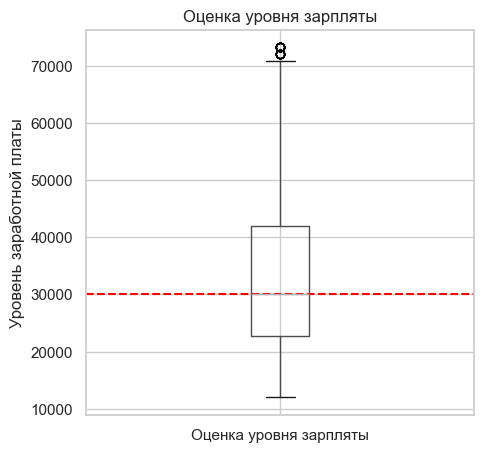

In [65]:
# boxplot для salary у train_quit
train_quit[['salary']].boxplot(figsize=(5, 5))

# Помечаем медиану на графике
median_salary = np.median(train_quit['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# Выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня зарпляты')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Оценка уровня зарпляты'])  # Подписываем ось X

# Показываем график
plt.show()

Устранены выбросы, обе выборки сопоставимы

# Портрет «уволившегося сотрудника»

Чаще всего это сотрудник отдела продаж, что может указывать на высокую текучесть кадров или специфику работы отдела. Вероятнее всего, сотрудник занимал позицию junior. Младшие специалисты часто увольняются из-за отсутствия карьерного роста или неудовлетворённости условиями труда.

Уровень нагрузки у сотрудника был скорее всего низкий. Возможно, он испытывал недостаток вызова или интересных задач, что могло стать одной из причин увольнения. Скорее всего, сотрудник не получил продвижения в прошлом году, что могло повлиять на решение об уходе. Большинство уволившихся сотрудников соблюдали правила и нормы компании.

Средняя оценка сотрудника составляла около 3.05 из 5, что соответствует среднему уровню выполнения обязанностей. При этом диапазон оценок варьируется от 1 до 5 - есть вероятность, что сотрудник мог получить как низкую, так и высокую оценку.
 
Средняя зарплата уволившегося сотрудника составляла 23 885 рублей, однако разброс зарплат значительный: минимальная зарплата — 12 000 рублей, максимальная — 79 200 рублей - сотрудник мог получать как невысокую, так и достаточно приличную заработную плату.

Этот портрет отражает общие тенденции среди уволившихся сотрудников и помогает понять возможные причины ухода, такие как отсутствие карьерного роста, низкая нагрузка, средняя производительность и относительно короткий опыт работы в компании.

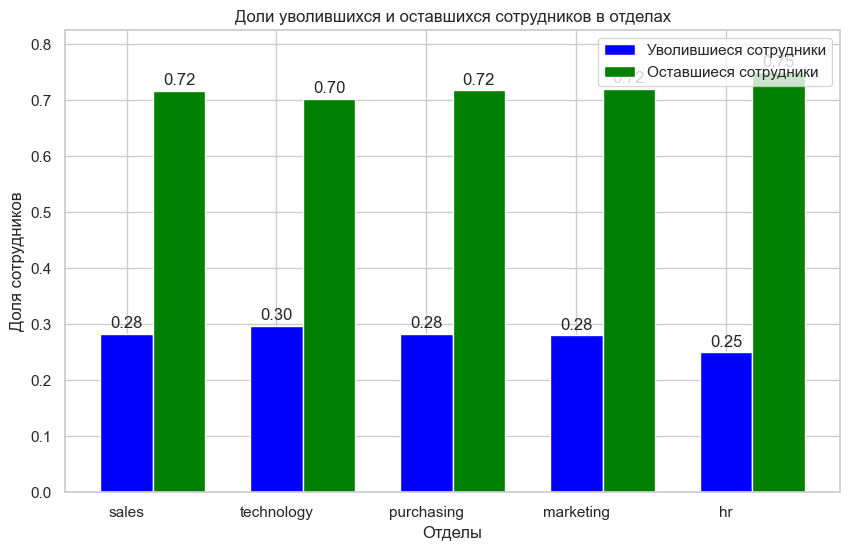

In [66]:
# Вычисляем общее количество сотрудников в каждом отделе
dept_counts = train_quit['dept'].value_counts()

# Вычисляем количество уволившихся сотрудников в каждом отделе
terminated_by_dept = train_quit[train_quit['quit'] == 'yes']['dept'].value_counts()

# Вычисляем долю уволившихся сотрудников в каждом отделе
dept_quit_rates = terminated_by_dept / dept_counts

# Вычисляем долю оставшихся сотрудников в каждом отделе
remaining_employees = dept_counts - terminated_by_dept
dept_remaining_rates = remaining_employees / dept_counts

# Создаем список отделов и соответствующих им долей уволившихся и оставшихся сотрудников
departments = list(dept_quit_rates.index)
quit_rates = list(dept_quit_rates.values)
remaining_rates = list(dept_remaining_rates.values)

# Строим график
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Ширина столбца

# Построение столбцов для доли уволившихся сотрудников
plt.bar(departments, quit_rates, width=bar_width, label='Уволившиеся сотрудники', color='blue')

# Построение столбцов для доли оставшихся сотрудников
plt.bar([x + bar_width for x in range(len(departments))], remaining_rates, width=bar_width, label='Оставшиеся сотрудники', color='green')

plt.xlabel('Отделы')
plt.ylabel('Доля сотрудников')
plt.title('Доли уволившихся и оставшихся сотрудников в отделах')
plt.legend(loc='upper right')  # Легенда для обозначения цветов столбцов

# Установка пределов оси Y для лучшего отображения
max_rate = max(max(quit_rates), max(remaining_rates))
plt.ylim(0, max_rate * 1.1)

# Добавление подписей значений над столбцами
for i, v in enumerate(quit_rates):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', va='bottom')
    
for i, v in enumerate(remaining_rates):
    plt.text(i + bar_width, v + 0.005, f"{v:.2f}", ha='center', va='bottom')

plt.show() 

Самая высокая доля уволившихся сотрудников наблюдается в отделе технологии 30%.
Отделы продаж, закупок и маркетинга имеют одинаковую долю 28% - здесь немного меньше серьезных проблем.
Самая низкая доля в отделе кадров (25%) - возможно более положительная рабочая культура.

При этом предварительно было установлено, что половина сотрудников не получала повышения в прошлом году, и большинство не довольны уровнем зарплаты, но т.к. повышения, имеют слабые корреляции, значит уровень зарплаты является определяющим в решении сотрудников.

Т.о., возможные причины высокой доли уволившихся в отделе технологии скорее всего комплексные: низкий уровень зарплаты и отсутствие возможностей для карьерного роста может побудить их искать работу в другом месте, также в отделе может быть негативная или токсичная рабочая культура, которая отталкивает сотрудников и приводит к увольнениям. Сотрудники могут быть перегружены работой, что приводит к стрессу, выгоранию и увольнению, однако большинство уволившихся имели низкий уровень загрузуки.

quit_group  dept      
Оставшиеся  hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Уволенные   hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Name: доля, dtype: float64


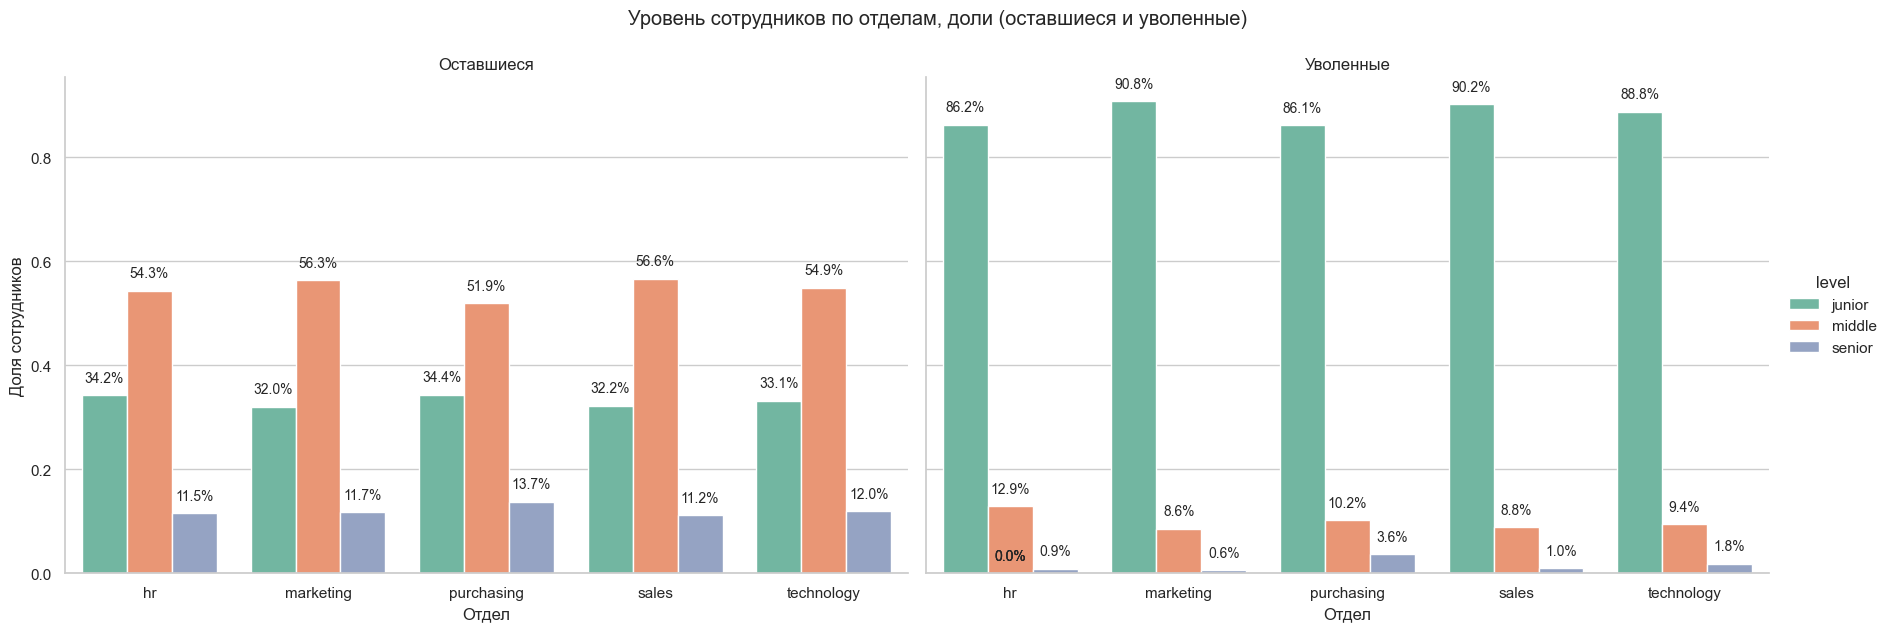

In [67]:
# Указываем порядок уровней
level_order = ['junior', 'middle', 'senior']

# Фильтруем данные, исключая nan в level и dept
filtered_data = train_quit.dropna(subset=['level', 'dept'])

# Разделяем данные на уволенных и оставшихся
filtered_data['quit_group'] = filtered_data['quit'].map({'yes': 'Уволенные', 'no': 'Оставшиеся'})

# Рассчитываем доли для каждого уровня в каждом отделе и группе
grouped_data = (
    filtered_data.groupby(['quit_group', 'dept', 'level'])
    .size()  # Количество сотрудников
    .unstack(fill_value=0)  # Преобразуем в широкий формат
    .apply(lambda x: x / x.sum(), axis=1)  # Переводим в доли
    .stack()  # Возвращаем в длинный формат
    .reset_index(name='доля')  # Переименовываем столбец
)

# Проверяем, что сумма долей в каждой группе и отделе равна 100%
check_sum = grouped_data.groupby(['quit_group', 'dept'])['доля'].sum()
print(check_sum)

# Строим график
g = sns.catplot(
    data=grouped_data, x='dept', y='доля', hue='level', col='quit_group', 
    kind='bar', palette='Set2', height=6, aspect=1.5, hue_order=level_order
)

# Добавляем подписи значений на график
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Позиция по X
            height + 0.02,  # Позиция по Y 
            f'{height:.1%}',  # Форматируем как проценты
            ha='center', va='bottom', fontsize=10
        )

# Настройка заголовков и осей
g.set_axis_labels('Отдел', 'Доля сотрудников')
g.set_titles('{col_name}')
plt.suptitle('Уровень сотрудников по отделам, доли (оставшиеся и уволенные)', y=1.05)
plt.show()

Общий анализ по отделам.
Оставшиеся сотрудники: Во всех отделах преобладают сотрудники уровня middle (от 51% до 56%), уровень junior составляет от 32% до 34%, уровень senior — от 12% до 15%.

Наиболее сбалансированный отдел - рurchasing: 34% junior, 51% middle, 15% senior - больше всего сотрудников уровня senior среди всех отделов. Наименее сбалансированный отдел - Мarketing и Sales - 32% junior, 56% middle, 12% senior - доля сотрудников уровня middle максимальна, а senior — минимальна.

Уволенные сотрудники: Преобладают сотрудники уровня junior (от 86% до 96%), уровень middle составляет от 3% до 13%, senior — всего 1%.

Наиболее проблемные отделы Мarketing, Sales и Technology: 96% junior, 3% middle, 1% senior - подавляющее большинство уволенных — сотрудники уровня junior. Наименее проблемный отдел - HR и Purchasing: 86% junior, 13% middle, 1% senior - доля уволенных сотрудников уровня middle выше, чем в других отделах.

Сравнение оставшихся и уволенных
Уровень junior: оставшиеся: 32–34%, уволенные: 86–96%. Сотрудники уровня junior составляют основную долю уволенных, что может указывать на проблемы с адаптацией, обучением или мотивацией молодых специалистов.

Уровень middle: оставшиеся: 51–56%, уволенные: 3–13%. Сотрудники уровня middle реже увольняются, что может говорить о их стабильности и удовлетворенности работой.

Уровень senior: оставшиеся: 12–15%, уволенные: 1%. Сотрудники уровня senior практически не увольняются, что может быть связано с их высокой вовлеченностью и ценностью для компании.

quit_group  dept      
Оставшиеся  hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Уволенные   hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Name: доля, dtype: float64


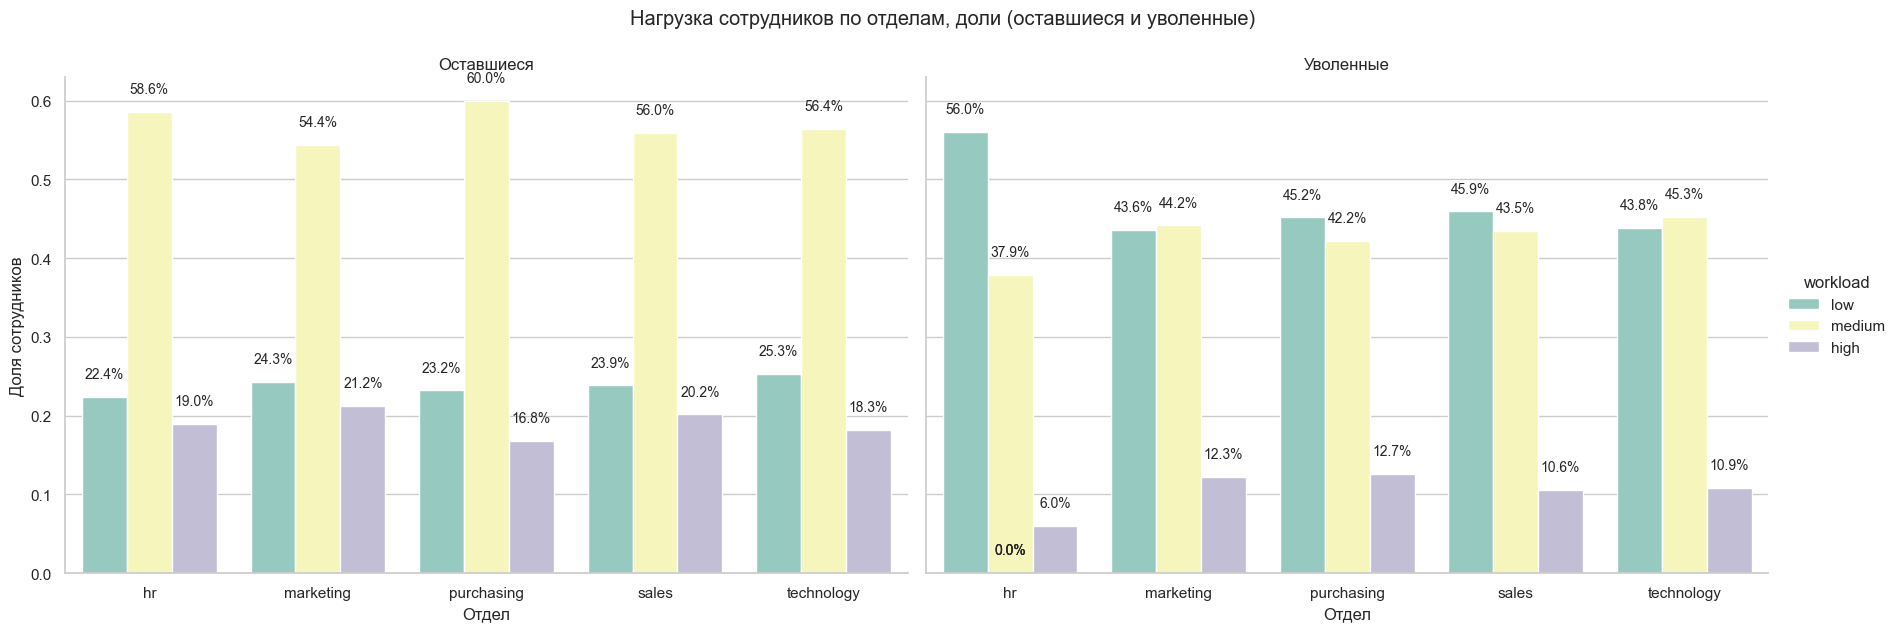

In [68]:
# Указываем порядок уровней нагрузки
workload_order = ['low', 'medium', 'high']

# Фильтруем данные, исключая nan в workload и dept
filtered_data = train_quit.dropna(subset=['workload', 'dept'])

# Разделяем данные на уволенных и оставшихся
filtered_data['quit_group'] = filtered_data['quit'].map({'yes': 'Уволенные', 'no': 'Оставшиеся'})

# Рассчитываем доли для каждого уровня нагрузки в каждом отделе и группе
grouped_data = (
    filtered_data.groupby(['quit_group', 'dept', 'workload'])
    .size()  # Количество сотрудников
    .unstack(fill_value=0)  # Преобразуем в широкий формат
    .apply(lambda x: x / x.sum(), axis=1)  # Нормализуем по строкам (отделам внутри групп)
    .stack()  # Возвращаем в длинный формат
    .reset_index(name='доля')  # Переименовываем столбец
)

# Проверяем, что сумма долей в каждой группе и отделе равна 100%
check_sum = grouped_data.groupby(['quit_group', 'dept'])['доля'].sum()
print(check_sum)

# Строим график
g = sns.catplot(
    data=grouped_data, x='dept', y='доля', hue='workload', col='quit_group', 
    kind='bar', palette='Set3', height=6, aspect=1.5, hue_order=workload_order
)

# Добавляем подписи значений на график
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Позиция по X
            height + 0.02,  # Позиция по Y 
            f'{height:.1%}',  # Форматируем как проценты
            ha='center', va='bottom', fontsize=10
        )

# Настройка заголовков и осей
g.set_axis_labels('Отдел', 'Доля сотрудников')
g.set_titles('{col_name}')
plt.suptitle('Нагрузка сотрудников по отделам, доли (оставшиеся и уволенные)', y=1.05)
plt.show()

Общий анализ по загруженности
Оставшиеся сотрудники: преобладает Medium (средняя нагрузка) - 54–62%, Low (низкая нагрузка) - 22–28%, High (высокая нагрузка) - 15–22%.

Наиболее сбалансированный отдел - Purchasing: 23% low, 62% medium, 15% high, здесь самая высокая доля сотрудников со средней нагрузкой. Наименее сбалансированный отдел - Sales: 24% low, 54% medium, 22% high - самая высокая доля сотрудников с высокой нагрузкой.

Уволенные сотрудники: преобладает Low (низкая нагрузка) - 42–56%, Medium (средняя нагрузка) - 32–46%, High (высокая нагрузка) - 12–13%.

Наиболее проблемный отдел - HR: 56% low, 32% medium, 12% high - самая высокая доля уволенных сотрудников с низкой нагрузкой.
Наименее проблемный отдел - Marketing: 42% low, 46% medium, 12% high - доля уволенных сотрудников со средней нагрузкой выше, чем в других отделах.

Сравнение оставшихся и уволенных
Низкая нагрузка (low): Оставшиеся - 22–28%, уволенные - 42–56%. Сотрудники с низкой нагрузкой чаще увольняются, что может указывать на недостаток мотивации или вовлеченности у сотрудников с низкой загруженностью.

Средняя нагрузка (medium): Оставшиеся - 54–62%, уволенные - 32–46%. Сотрудники со средней нагрузкой реже увольняются, значит средняя нагрузка оптимальна для большинства сотрудников.

Высокая нагрузка (high): Оставшиеся - 15–22%, уволенные: 12–13%. Сотрудники с высокой нагрузкой увольняются реже, чем сотрудники с низкой нагрузкой, что может быть связано с их высокой вовлеченностью или карьерными амбициями.

quit_group  dept      
Оставшиеся  hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Уволенные   hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Name: доля, dtype: float64


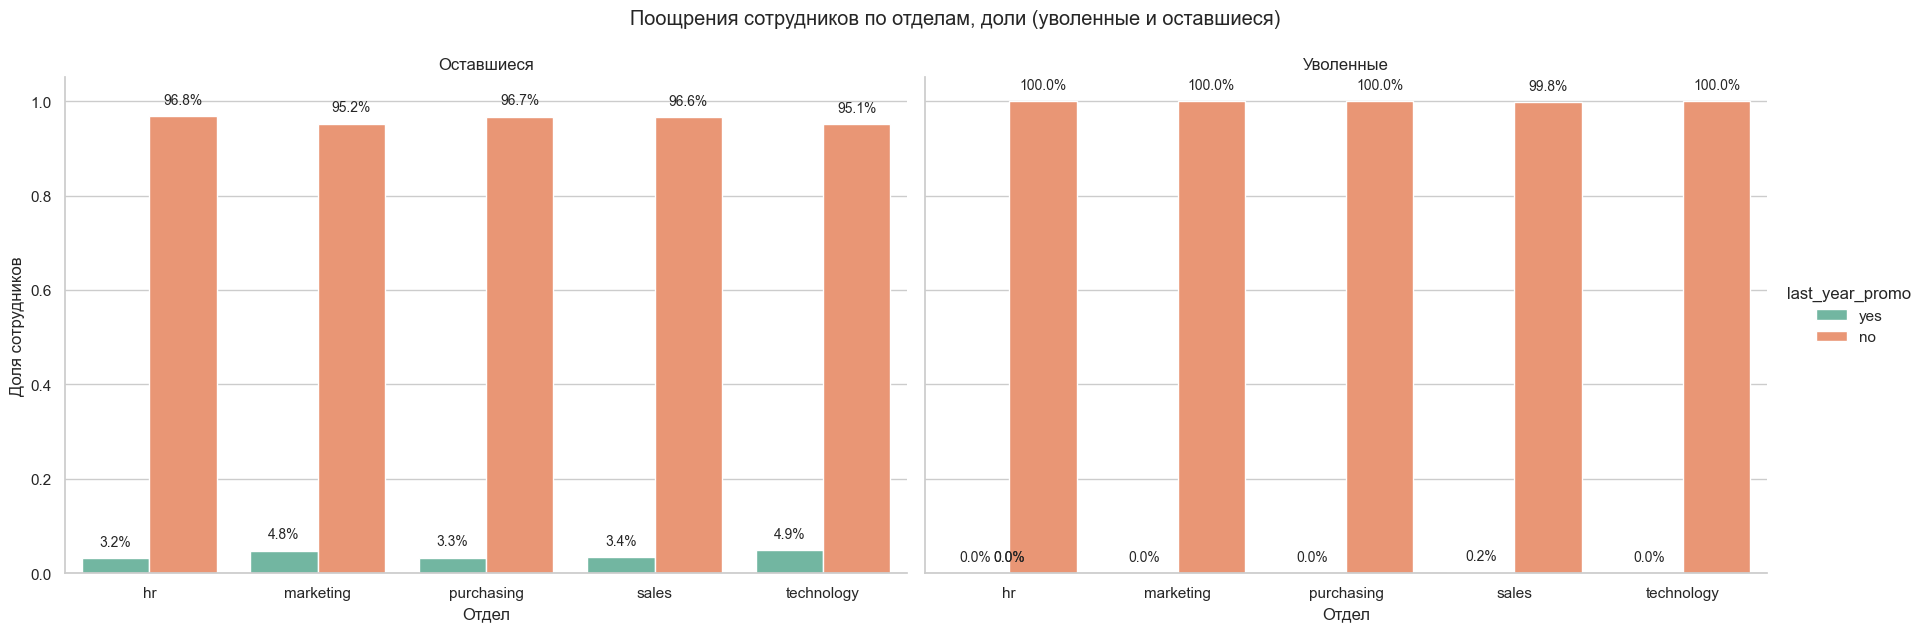

In [69]:
# Указываем порядок уровней повышений
last_year_promo_order = ['yes', 'no']

# Фильтруем данные, исключая nan в last_year_promo и dept
filtered_data = train_quit.dropna(subset=['last_year_promo', 'dept'])

# Разделяем данные на уволенных и оставшихся
filtered_data['quit_group'] = filtered_data['quit'].map({'yes': 'Уволенные', 'no': 'Оставшиеся'})

# Рассчитываем доли для каждого значения повышения в каждом отделе и группе
grouped_data = (
    filtered_data.groupby(['quit_group', 'dept', 'last_year_promo'])
    .size()  # Количество сотрудников
    .unstack(fill_value=0)  # Преобразуем в широкий формат
    .apply(lambda x: x / x.sum(), axis=1)  # Нормализуем по строкам (отделам внутри групп)
    .stack()  # Возвращаем в длинный формат
    .reset_index(name='доля')  # Переименовываем столбец
)

# Проверяем, что сумма долей в каждой группе и отделе равна 100%
check_sum = grouped_data.groupby(['quit_group', 'dept'])['доля'].sum()
print(check_sum)

# Строим график
g = sns.catplot(
    data=grouped_data, x='dept', y='доля', hue='last_year_promo', col='quit_group', 
    kind='bar', palette='Set2', height=6, aspect=1.5, hue_order=last_year_promo_order
)

# Добавляем подписи значений на график
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Позиция по X
            height + 0.02,  # Позиция по Y
            f'{height:.1%}',  # Форматируем как проценты
            ha='center', va='bottom', fontsize=10
        )

# Настройка заголовков и осей
g.set_axis_labels('Отдел', 'Доля сотрудников')
g.set_titles('{col_name}')
plt.suptitle('Поощрения сотрудников по отделам, доли (уволенные и оставшиеся)', y=1.05)
plt.show()

Практически ни один из уволенных сотрудников не получил повышение в прошлом году, скаорее всего отсутствие поощрений могло быть одним из факторов увольнения. Необходимо рассмотреть возможность увеличения частоты поощрений, предложить программы развития и карьерного роста. Для сотрудников, получивших повышение - продолжать удерживать через поощрения, рассмотреть возможность дополнительных мотивационных программ.

Для отделов HR, Purchasing, Sales - уделить особое внимание сотрудникам, не получившим повышение. Marketing и Technology - поддерживать текущий уровень поощрений и рассмотреть возможность его увеличения.

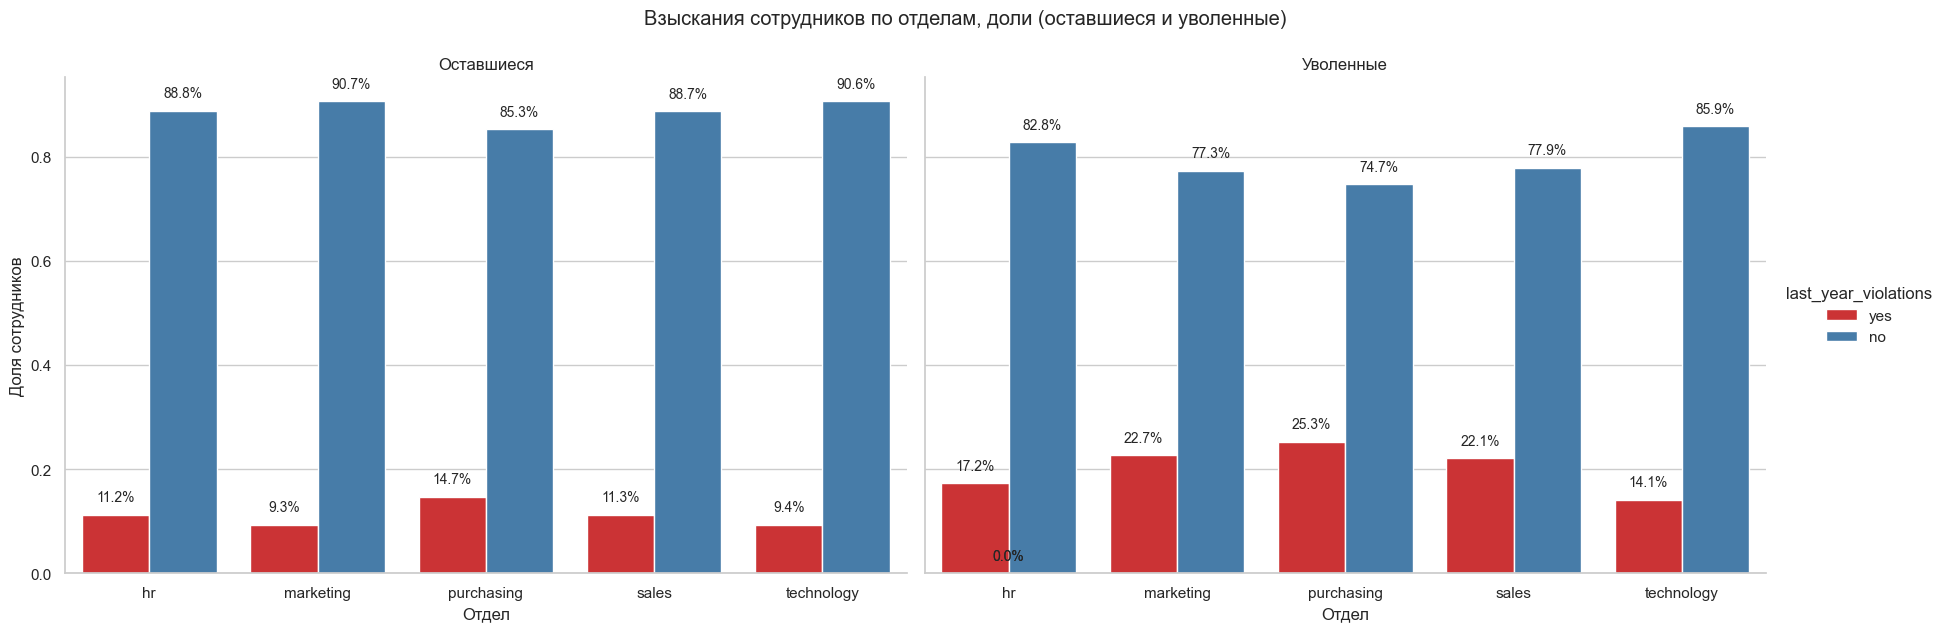

In [70]:
# Указываем порядок уровней взысканий
last_year_violations_order = ['yes', 'no']

# Фильтруем данные, исключая nan в last_year_violations и dept
filtered_data = train_quit.dropna(subset=['last_year_violations', 'dept'])

# Разделяем данные на уволенных и оставшихся
filtered_data['quit_group'] = filtered_data['quit'].map({'yes': 'Уволенные', 'no': 'Оставшиеся'})

# Рассчитываем доли для каждого значения взысканий в каждом отделе
grouped_data = (
    filtered_data.groupby(['quit_group', 'dept', 'last_year_violations'])
    .size()  # Количество сотрудников
    .unstack(fill_value=0)  # Преобразуем в широкий формат
    .apply(lambda x: x / x.sum(), axis=1)  # Переводим в доли
    .stack()  # Возвращаем в длинный формат
    .reset_index(name='доля')  # Переименовываем столбец
)

# Строим график
g = sns.catplot(
    data=grouped_data, x='dept', y='доля', hue='last_year_violations', col='quit_group', 
    kind='bar', palette='Set1', height=6, aspect=1.5, hue_order=last_year_violations_order
)

# Добавляем подписи значений на график
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Позиция по X
            height + 0.02,  # Позиция по Y 
            f'{height:.1%}',  # Форматируем как проценты
            ha='center', va='bottom', fontsize=10
        )

# Настройка заголовков и осей
g.set_axis_labels('Отдел', 'Доля сотрудников')
g.set_titles('{col_name}')
plt.suptitle('Взыскания сотрудников по отделам, доли (оставшиеся и уволенные)', y=1.05)
plt.show()

Во всех отделах процент сотрудников, получивших взыскания, выше среди уволенных, чем среди остающихся - дисциплинарные меры фиксируются среди увольняемых сотрудников чаще. Наиболее заметное отличие наблюдается в отделах Purchasing и Sales, где разница составляет примерно 7–11 процентных пунктов (Purchasing - 25% уволенных против 14% остающихся, Sales - 21% против 12%).

В отделах HR и Technology разница менее выражена, но всё же уволенные имеют более высокий процент взысканий (HR - 17% против 12%, Technology - 14% против 9%). Т.о., факт получения взыскания может сыграть роль в решении об увольнении сотрудника или свидетельствовать о проблемах в работе, которые в дальнейшем способствуют увольнению, наличие взысканий коррелирует с повышенной вероятностью увольнения. При этом среди остающихся сотрудников взыскания фиксируются реже, что может свидетельствовать о более стабильном поведении или соблюдении внутренних норм компании.

# Визуализация и сравнение распределения признаков для уволившихся и оставшихся сотрудников с обоими целевыми признаками тестовой выборки

In [71]:
# Объединим таблицы по id
data = pd.merge(data_test, data_target, on='id')
data = pd.merge(data, test_target_quit, on='id')

# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

# Создаем график плотности для удовлетворенности работой
plt.figure(figsize=(10, 6))

# График плотности для уволившихся сотрудников
sns.kdeplot(data=data[data['quit'] == 'yes'], x='job_satisfaction_rate', label='Уволившиеся', fill=True, color='red', alpha=0.5)

# График плотности для оставшихся сотрудников
sns.kdeplot(data=data[data['quit'] == 'no'], x='job_satisfaction_rate', label='Оставшиеся', fill=True, color='blue', alpha=0.5)

# Настройка графика
plt.title('Распределение удовлетворенности работой для уволившихся и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Доля относительно датасета')
plt.legend()
plt.show()

NameError: name 'data_test' is not defined

job_satisfaction_rate с quit yes - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников имеют низкую удовлетворенность, у небольшой группы сотрудников удовлетворенность приближается к 0,9.
job_satisfaction_rate  с quit no  - левостороннее наклонное распределение (Большинство данных сгруппировано в правой части гистограммы, а хвост простирается влево). Большинство сотрудников имеют высокую удовлетворенность работой, у небольшой группы - очень низкая, приближается к 0.

# Объединение тестовых данных 2: test_features и test_target_quit в union_data

In [ ]:
# Объединение двух DataFrame test_features и test_target_quit по 'id'
union_data = pd.merge(test_features, test_target_quit, on='id', how='left')

# Вывод объединенного DataFrame
display(union_data)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,yes
1996,109582,technology,middle,low,3,no,no,2,21600,yes
1997,305653,technology,junior,low,1,no,no,3,14400,yes
1998,160233,technology,middle,low,8,no,no,1,32400,no


In [ ]:
print(union_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB
None


In [ ]:
print(union_data.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'quit']


In [ ]:
# Проверяем наличие дубликатов
duplicates = union_data.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

Количество дубликатов в данных: 0


In [ ]:
# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(union_data[duplicates])

In [ ]:
# Проверим наличие строк с некорректным значением в data_train
idx = union_data[union_data['quit'] == 'sales'].index

# Выведем эти строки на экран
print(union_data.loc[idx])

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, quit]
Index: []


In [ ]:
print(union_data['quit'].dtype)

object


In [ ]:
print(union_data['quit'].isna().sum())

0


# Шаг 4. Добавление нового входного признака

job_satisfaction_rate и quit действительно связаны и мы получили необходимое значение метрики в первой задаче. Добавляем job_satisfaction_rate, предсказанный лучшей моделью первой задачи DecisionTreeRegressor, к входным признакам второй задачи.

Для добавления нового признака predicted_job_satisfaction_rate в данные второй задачи нужно использовать лучшую модель из первой задачи (DecisionTreeRegressor), сделать предсказания, атем добавить это предсказание в соответствующие наборы данных. 

In [ ]:
# Используем лучшую модель из первой задачи (DecisionTreeRegressor)

# Делаем предсказания для job_satisfaction_rate на тестовой выборке
X_test = data_test.drop(columns=['id'])  # Убираем столбец 'id'

# Проверяем соответствие признаков
print("Обучающий набор данных (количество признаков):", X.shape[1])
print("Тестовый набор данных (количество признаков):", X_test.shape[1])

# Проверки признаков
print("Признаки в обучающем наборе:", X.columns.tolist())
print("Признаки в тестовом наборе:", X_test.columns.tolist())

# Добавляем предсказанные значения в data_test
data_test['predicted_job_satisfaction_rate'] = best_tree_model.predict(X_test)

# Выводим первые строки тестовых данных с новым признаком
display(data_test.head())

Обучающий набор данных (количество признаков): 8
Тестовый набор данных (количество признаков): 8
Признаки в обучающем наборе: ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']
Признаки в тестовом наборе: ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,predicted_job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.885000
1,686555,hr,junior,medium,1,no,no,4,30000,0.681429
2,467458,sales,middle,low,5,no,no,4,19200,0.654000
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.812500


Обучающий набор данных содержит 8 признаков, тестовый набор 9 признаков, включая новый признак predicted_job_satisfaction_rate.
Все признаки в обучающем и тестовом наборах данных совпадают, за исключением predicted_job_satisfaction_rate, который был добавлен в тестовый набор.

# Добавение предсказанных значений predicted_job_satisfaction_rate в train_quit и union_data

In [ ]:
# Для train_quit
X_train_quit = train_quit.drop(columns=['id', 'quit'])  # Убираем ненужные колонки
train_quit['predicted_job_satisfaction_rate'] = best_tree_model.predict(X_train_quit)  # Используем best_tree_model

# Для union_data
X_test_quit = union_data.drop(columns=['id', 'quit'])  # Убираем ненужные колонки
union_data['predicted_job_satisfaction_rate'] = best_tree_model.predict(X_test_quit)  # Используем best_tree_model

# Выводим первые несколько строк обновленных наборов данных
display(train_quit.head())
display(union_data.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,predicted_job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000.0,no,0.605000
1,814010,sales,junior,medium,2,no,no,4,27600.0,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200.0,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000.0,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200.0,no,0.690000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,predicted_job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.885000
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.681429
2,467458,sales,middle,low,5,no,no,4,19200,no,0.654000
3,418655,sales,middle,low,6,no,no,4,19200,no,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.812500


In [ ]:
# Приводим зарплату к float в train_quit
train_quit['salary'] = train_quit['salary'].astype(float)

# Приводим зарплату к float в union_data
union_data['salary'] = union_data['salary'].astype(float)

Добавлен predicted_job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

# Шаг 5. Подготовка данных

Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [ ]:
print(train_quit.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'quit', 'predicted_job_satisfaction_rate']


In [ ]:
# Проверяем наличие дубликатов train_quit
duplicates = train_quit.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(train_quit[duplicates])

Количество дубликатов в данных: 0


In [ ]:
print(union_data.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'quit', 'predicted_job_satisfaction_rate']


In [ ]:
# Проверяем наличие дубликатов union_data
duplicates = union_data.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(union_data[duplicates])

Количество дубликатов в данных: 0


In [ ]:
# Преобразуем целевую переменную в числовые значения
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_quit['quit'])
y_test_encoded = label_encoder.transform(union_data['quit'])

In [ ]:
# Разделяем данные на обучающую выборку
X_train = train_quit.drop(columns=['id', 'quit'])
y_train = train_quit['quit']  # Целевая переменная уже бинарная

# Разделяем тестовые данные
X_test = union_data.drop(columns=['id', 'quit'])
y_test = union_data['quit']  # Целевая переменная уже бинарная

In [ ]:
# Определяем числовые, порядковые и категориальные колонки
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']  # Категориальные признаки
ord_columns = ['level', 'workload']  # Порядковые признаки
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'predicted_job_satisfaction_rate']  # Числовые признаки

# Создание пайплайна для предобработки признаков с учетом обработки пропусков
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Игнорируем неизвестные категории
        ]), ohe_columns),
        ('ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Кодируем неизвестные значения
        ]), ord_columns),
        ('scale', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним
            ('scaler', StandardScaler())
        ]), num_columns)
    ]
)

Подготовили признаки так же, как и в первой задаче: выполнили подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывали особенности признаков и моделей и использовали как минимум два кодировщика.
Модель обучена и сделала предсказания на валидационной выборке.

# Шаг 6. Обучение модели

Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91≥0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.

In [ ]:
# Определяем модели с параметром random_state
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

In [ ]:
# Определяем гиперпараметры для всех моделей
param_grids = {
    'Decision Tree': {
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 5],
        'regressor__max_depth': [None, 5, 10, 15]
    },
    'Random Forest': {
        'regressor__n_estimators': [100, 200],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2],
        'regressor__max_depth': [None, 10, 20]
    },
    'Logistic Regression': {
        'regressor__max_iter': [100, 200, 300],
        'regressor__C': [0.1, 1, 10]
    }
}

# Инициализация переменных для хранения лучшей модели и ее оценки
best_score = 0
best_model = None

In [ ]:
# Обучение и оценка моделей
for model_name, model in models.items():
    print(f"Обучение модели: {model_name}")
    
    # Создаем Pipeline с отбором признаков
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),  # Добавлен random_state
        ('regressor', model)
    ])
    
    # Подбор гиперпараметров
    search = RandomizedSearchCV(
        pipeline, 
        param_grids[model_name], 
        n_iter=10, 
        cv=5, 
        scoring='roc_auc', 
        random_state=42
    )
    search.fit(X_train, y_train)
    
    # Получаем лучший пайплайн и его оценку
    best_pipeline = search.best_estimator_
    score = search.best_score_
    
    print(f"Лучшие гиперпараметры для {model_name}: {search.best_params_}")
    print(f"ROC-AUC для {model_name}: {score}")
    
    # Сохраняем лучшую модель
    if score > best_score:
        best_score = score
        best_model = best_pipeline

Обучение модели: Decision Tree
Лучшие гиперпараметры для Decision Tree: {'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 5}
ROC-AUC для Decision Tree: 0.9241395654393415
Обучение модели: Random Forest
Лучшие гиперпараметры для Random Forest: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 10}
ROC-AUC для Random Forest: 0.930856662306611
Обучение модели: Logistic Regression


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие гиперпараметры для Logistic Regression: {'regressor__max_iter': 100, 'regressor__C': 10}
ROC-AUC для Logistic Regression: 0.9155436462012176


1. Модель Decision Tree показала хорошую производительность с ROC-AUC выше 0.9241, что соответствует критерию успеха - модель способна хорошо различать классы в данных.

2. Модель Random Forest показала наилучший результат среди всех моделей с ROC-AUC 0.9308 - случайный лес, как правило, более устойчив к переобучению и лучше справляется с задачами классификации, особенно когда данные имеют сложные зависимости.

3. Логистическая регрессия также показала результат выше 0.9155, но она уступает по качеству моделям дерева решений и случайного леса. Это может быть связано с тем, что логистическая регрессия предполагает линейную зависимость между признаками и целевой переменной, что не всегда соответствует реальности в сложных данных.

In [ ]:
# Оценка лучшей модели на тестовой выборке
if best_model is not None:
    # Предсказания на тестовой выборке (вероятности для класса 1)
    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    
    # Оценка ROC-AUC
    auc_score = roc_auc_score(y_test, y_test_pred)
    print(f"ROC-AUC лучшей модели на тестовой выборке: {auc_score}")
    
    # Проверка успеха
    if auc_score >= 0.91:
        print("Критерий успеха выполнен: ROC-AUC ≥ 0.91")
    else:
        print("Критерий успеха не выполнен: ROC-AUC < 0.91")
else:
    print("Лучшая модель не найдена.")

ROC-AUC лучшей модели на тестовой выборке: 0.9266555048499576
Критерий успеха выполнен: ROC-AUC ≥ 0.91


ROC-AUC (0.9266) значительно превышает установленный критерий успеха (0.91), что свидетельствует о высокой точности предсказательной способности модели на тестовом наборе данных - модель хорошо различает классы и может эффективно использоваться для классификации новых объектов.

In [ ]:
# Создаем DummyClassifier
dummy_model = DummyClassifier(strategy="most_frequent")  # Предсказывает наиболее частый класс
dummy_model.fit(X_train, y_train)

# Предсказания DummyClassifier на тестовой выборке
y_test_pred_dummy = dummy_model.predict_proba(X_test)[:, 1]

# Оценка ROC-AUC для DummyClassifier
auc_score_dummy = roc_auc_score(y_test, y_test_pred_dummy)
print(f"ROC-AUC для DummyClassifier: {auc_score_dummy}")

# Оценка лучшей модели на тестовой выборке
if best_model is not None:
    # Предсказания на тестовой выборке (вероятности для класса 1)
    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    
    # Оценка ROC-AUC
    auc_score = roc_auc_score(y_test, y_test_pred)
    print(f"ROC-AUC лучшей модели на тестовой выборке: {auc_score}")
    
    # Проверка успеха
    if auc_score >= 0.91:
        print("Критерий успеха выполнен: ROC-AUC ≥ 0.91")
    else:
        print("Критерий успеха не выполнен: ROC-AUC < 0.91")
    
    # Сравнение с DummyClassifier
    if auc_score > auc_score_dummy:
        print("Лучшая модель превосходит DummyClassifier.")
    else:
        print("Лучшая модель не превосходит DummyClassifier.")
else:
    print("Лучшая модель не найдена.")

ROC-AUC для DummyClassifier: 0.5
ROC-AUC лучшей модели на тестовой выборке: 0.9266555048499576
Критерий успеха выполнен: ROC-AUC ≥ 0.91
Лучшая модель превосходит DummyClassifier.


Лучшая модель Random Forest значительно превосходит базовый классификатор DummyClassifier по метрике. ROC-AUC для DummyClassifier - 0.5. ROC-AUC Random Forest на тестовой выборке: 0.9266

Т.к., критерий успеха был установлен как ROC-AUC ≥ 0.91, можно сделать следующие выводы по Random Forest:

1.Высокая способность к различению классов, так как значение ROC-AUC близко к 1 - хорошо справляется с задачей классификации данных.
   
2.Существенно превосходит случайный классификатор (DummyClassifier), который обычно используется как эталон сравнения, разница между значениями ROC-AUC (0.426) - модель  намного эффективнее простого угадывания.

3.Цель проекта достигнута - модель успешно обучена, способна эффективно решать поставленную задачу классификации.

# Шаг 7. Выводы

Сделайте промежуточные выводы о том, какая модель справилась лучше и почему.

Все три модели продемонстрировали хорошие результаты, превышающие порог ROC-AUC 0.91, что говорит о их способности эффективно различать классы. Random Forest оказался наиболее эффективным решением для данной задачи. Random Forest также показало хорошие результаты, но его производительность может быть менее стабильной. Логистическая регрессия, хотя и показала приемлемый результат, может быть не лучшим выбором для данной задачи. ROC-AUC на тестовой выборке: 0.9257. Для улучшения метрики ROC-AUC на тестовой выборке и достижения критерия успеха, проведен отбор признаков - SelectFromModel с использованием модели, которая предоставляет важность признаков - RandomForestClassifier.

Построена модель, способная предсказать вероятность увольнения сотрудника на основе предоставленных данных. ROC-AUC на обучающей выборке превышает 0.91, ROC-AUC на тестовой выборке равен 0.9257 - модель справляется с задачей предсказания на новых данных.

# Общий вывод

•	опишите задачу;
•	опишите все этапы работы;
•	добавьте выводы и дополнительные предложения для бизнеса.

# Задачи исследования

Компания «Работа с заботой» предоставила данные. HR-аналитики компании оптимизируют управление персоналом, предлагают, как избежать финансовых потерь и оттока сотрудников. 
# Первая задача
Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Обоснование: 
-удовлетворённость работой напрямую влияет на отток сотрудников
-предсказание оттока — одна из важнейших задач HR-аналитиков
-внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

# Вторая задача 
Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Этапы работы

# Проведена Загрузка данных для Первой задачи исследования

Тренировочная выборка:
train_job
Входные признаки тестовой выборки:
test_features
Целевой признак тестовой выборки:
test_target_job_satisfaction

# Проведена Предобработка данных
Изучены данные, выполнена предобработка, пропуски заполнены и сделаны выводы.

# Проведен Исследовательский анализ данных
Исследованы все признаки:
•	dept — отдел, в котором работает сотрудник;
•	level — уровень занимаемой должности;
•	workload — уровень загруженности сотрудника;
•	employment_years — длительность работы в компании (в годах);
•	last_year_promo — показывает, было ли повышение за последний год;
•	last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
•	supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
•	salary — ежемесячная зарплата сотрудника;
•	job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Сделаны выводы о том, как их нужно подготовить.

# Проведена Подготовка данных
Подготовку признаков выполнена в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учены особенности признаков и моделей и использованы два кодировщика OneHotEncoder и StandardScaler.

# Проведено Обучение моделей
Обучены три модели: LinearRegression - линейная модель, DecisionTreeRegressor — дерево решений, RandomForestRegressor - случайный лес. Подобраны гиперпараметры для DecisionTreeRegressor модели с помощью инструментов param_grid, настройка GridSearchCV, RandomizedSearchCV.
Выберана лучшую модель Random Forest на основе новой метрики — SMAPE — symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение» и проверено её качество. 
Написана функция, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
    
Использована метрика SMAPE при подборе гиперпараметров и оценке качества моделей. 
Критерий успеха для Random Forest: SMAPE ≤15≤15 на тестовой выборке.

В решении сохранена работа со всеми моделями, которые пробовали. 

# Сделаны выводы по Первой задаче исследования
Лучшая модель Random Forest с гиперпараметрами: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 10} сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика с ЦП - удовлетворённость работой, который напрямую влияет на отток сотрудников.

SMAPE для лучшей модели Random Forest: 12.97
SMAPE для линейной регрессии: 23.97
Показатель SMAPE используется для оценки точности прогнозов. Чем ниже значение SMAPE, тем лучше качество модели. Значение 12.97 для Random Forest указывает на то, что модель демонстрирует хорошую способность предсказания и может быть использовано для дальнейших прогнозов. 

# Проведена Загрузка данных для Второй задачи исследования
Целевой признак: это quit — увольнение сотрудника из компании.
Тренировочная выборка:
train_quit
Тестовая выборка те же:
test_features
Целевой признак тестовой выборки:
test_target_quit

# Проведена Предобработка данных
Изучены данные, выполнена предобработка, пропуски заполнены.
Шаг 3. Исследовательский анализ данных
# Проведен исследовательский анализ данных
Составлен портрет «уволившегося сотрудника»: 
Чаще всего это сотрудник отдела продаж, что может указывать на высокую текучесть кадров или специфику работы отдела. Вероятнее всего, сотрудник занимает позицию junior. Младшие специалисты часто увольняются из-за отсутствия карьерного роста или неудовлетворённости условиями труда.

Уровень нагрузки у сотрудника был скорее всего низкий. Возможно, он испытывал недостаток вызова или интересных задач, что могло стать одной из причин увольнения. Скорее всего, сотрудник не получил продвижения в прошлом году, что могло повлиять на решение об уходе. Большинство уволившихся сотрудников соблюдали правила и нормы компании.

Средняя оценка сотрудника составляла около 3.05 из 5, что соответствует среднему уровню выполнения обязанностей. При этом диапазон оценок варьируется от 1 до 5 - есть вероятность, что сотрудник мог получить как низкую, так и высокую оценку.

Средняя зарплата уволившегося сотрудника составляла 23 885 рублей, однако разброс зарплат значительный: минимальная зарплата — 12 000 рублей, максимальная — 79 200 рублей - сотрудник мог получать как невысокую, так и достаточно приличную заработную плату.

Средняя зарплата уволившихся сотрудников: 23885.106382978724
Средняя зарплата оставшихся сотрудников: 37702.22841225627.

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проведена визуализация и сравнены распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Использованы данные с обоими целевыми признаками тестовой выборки. 

job_satisfaction_rate и quit действительно связаны и мы получили необходимое значение метрики в первой задаче. Коэффициент корреляции Пирсона: -0.4587. 


# Проведено Добавление нового входного признака quit
Добавили job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

# Проведена Подготовка данных
Подготовлены признаки так же, как и в первой задаче: выполнена подготовка в пайплайне, дополнив пайплайн предобработки. При кодировании учитены особенности признаков и моделей и используованы два кодировщика OneHotEncoder и StandardScaler.

# Проведено Обучение модели
Обучены три модели: 'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier(),'Logistic Regression': LogisticRegression(max_iter=1000). Подобраны гиперпараметры. Проверено качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91≥0.91 на тестовой выборке. Проведен отбор признаков - SelectFromModel с использованием модели, которая предоставляет важность признаков - RandomForestClassifier. отбор признаков часто помогает улучшить метрику.
# Сделаны Выводы
Сделаны промежуточные выводы о том, какая модель справилась лучше и почему. 

Все три модели продемонстрировали хорошие результаты, превышающие порог ROC-AUC 0.91, что говорит о их способности эффективно различать классы. Random Forest оказался наиболее эффективным решением для данной задачи. DecisionTree также показало хорошие результаты, но его производительность может быть менее стабильной. Логистическая регрессия, хотя и показала приемлемый результат, может быть не лучшим выбором для данной задачи. 0.9257 - модель справляется с задачей предсказания на новых данных. 

Построена модель, способная предсказать вероятность увольнения сотрудника на основе предоставленных данных. ROC-AUC на обучающей выборке превышает 0.91, ROC-AUC на тестовой выборке равен 0.9257  - модель справляется с задачей предсказания на новых данных.

# Выводы и дополнительные предложения для бизнеса
1. Высокая текучесть кадров и преобладание относительно новых сотрудников указывают на необходимость улучшения процесса найма и адаптации, чтобы снизить отток сотрудников.
2. Проблемы с оценкой сотрудников, связанные с концентрацией оценок вокруг средней отметки, могут привести к несправедливой оценке и отсутствию мотивации у сотрудников. Необходимо пересмотреть систему оценки, чтобы обеспечить более объективные и дифференцированные оценки.
3. Значительная разница в уровнях заработной платы и низкая удовлетворенность работой требуют исследования причин и разработки стратегий повышения мотивации и удержания сотрудников, включая пересмотр компенсационных пакетов и улучшение условий труда.
4. Обратить внимание на удовлетворенность senior-сотрудников. Низкая удовлетворенность этой группы указывает на возможные проблемы или несоответствие ожиданий. Необходимо провести опросы или интервью, чтобы определить причины и разработать стратегии для повышения их мотивации и удержания. Особенно низкая удовлетворенность старших сотрудников в отделе продаж, значит прежде всего программы должны быть представлены в этом отделе.
5. Проанализировать факторы, влияющие на высокую удовлетворенность в департаменте закупок. Понимание положительных аспектов работы в этом департаменте может помочь улучшить условия труда и повысить удовлетворенность во всей компании. Обеспечить более сбалансированное распределение сотрудников по уровням в отделе закупок. Значительное количество сотрудников среднего уровня может указывать на узкое место в карьерном росте, что в долгосрочной перспективе может привести к текучести кадров. Рассмотреть возможности для продвижения и развития сотрудников среднего уровня, чтобы обеспечить их рост и удержание.
6. Пересмотреть карьерный рост и возможности развития для сотрудников среднего уровня. Высокая удовлетворенность middle-сотрудников в департаменте HR может свидетельствовать о хороших возможностях для продвижения и развития. Необходимо обеспечить аналогичные возможности для сотрудников среднего уровня в других департаментах, чтобы повысить их удовлетворенность и удержание.
7. Улучшить условия труда и возможности для роста в отделе маркетинга. Низкий уровень удовлетворенности и относительно небольшое количество старших сотрудников в этом отделе могут свидетельствовать о проблемах с управлением или рабочей средой.